In [3]:
import os

os.chdir("../../../")  # Ensure Current working directory is top level folder where venv is.

import os.path
import math

import numpy as np
import matplotlib.pyplot as plt

from source.models.noise.noise_sweep import NoiseSweep
from source.models.noise.simple_noise_packet_psd import SimpleNoisePacketPSD
from source.services.hidfmux_pkl_file_load_service import HidfmuxFileLoadService
from source.util import (
    resonator_noise_analysis_tools,
)
from source.util import data_processing_tools



In [4]:

multi_tone_directory=r"C:\Users\c2047423\OneDrive - Cardiff University\Documents\Gethin - PhD\Device Data\SPT-SLIM\v2_anlw001_ppcaps\Ice_board_data\140mK_0p001_amp"
dut="slim_v2_anlw001_ppcaps"
temperature=0.14
plot_sweeps=True
plot_timestreams=True
plot_psd=True
save_figures=False
tone_indices=list(range(0, 7))


In [5]:
multi_tone_timestreams = HidfmuxFileLoadService.load_multi_tone_pkl_timestreams(
timestream_directory=multi_tone_directory
)

1/101 Timestreams loaded
2/101 Timestreams loaded
3/101 Timestreams loaded
4/101 Timestreams loaded
5/101 Timestreams loaded
6/101 Timestreams loaded
7/101 Timestreams loaded


Percentage uncertainty: 0.21468299266148275


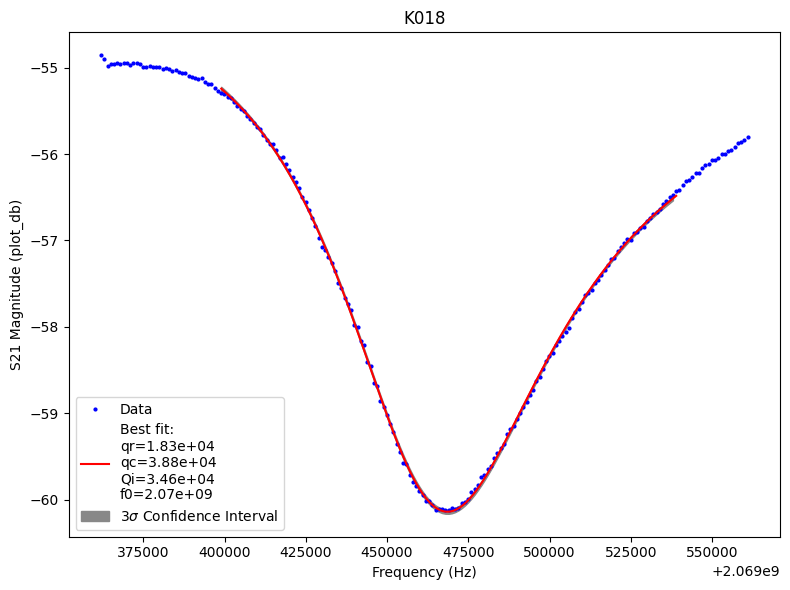

Percentage uncertainty: 0.22372670479718587


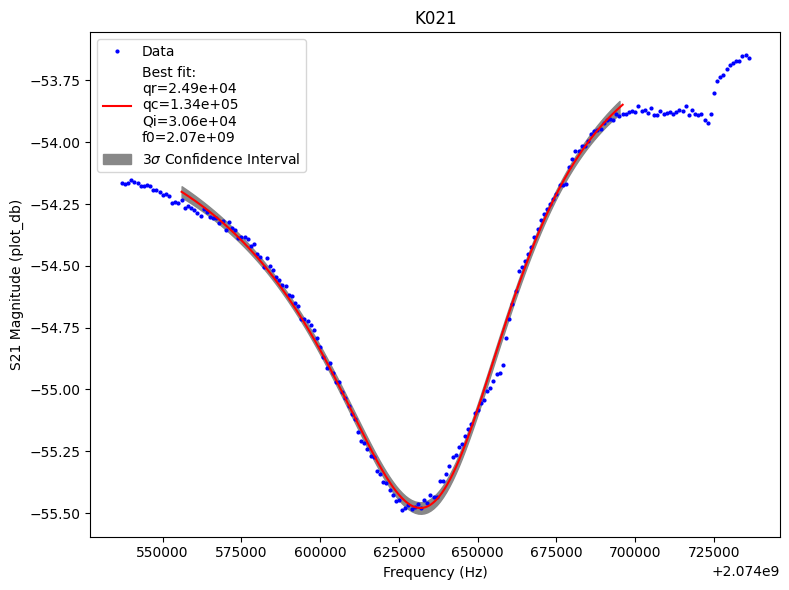

Percentage uncertainty: 0.250223810945787


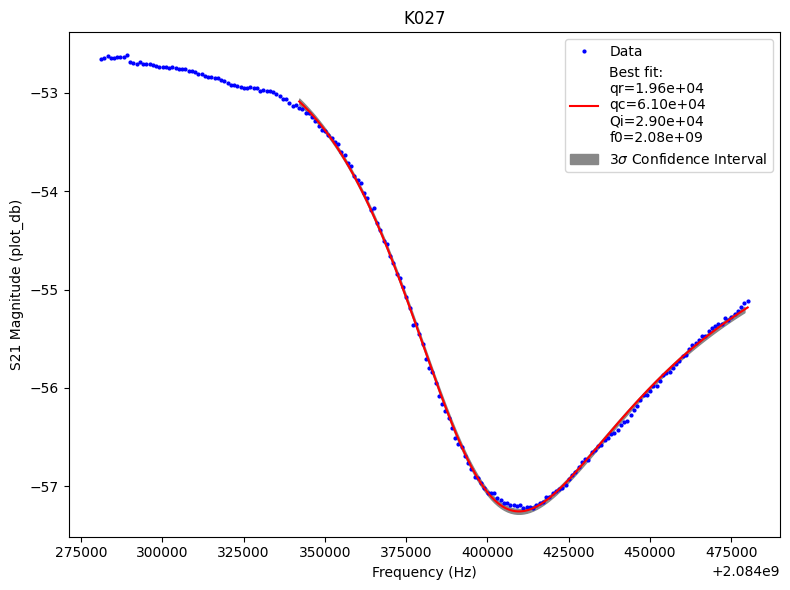

Percentage uncertainty: 0.3029900668062379


Total good KIDs: 4
['K018' 'K021' 'K027' 'K033']
Total No Peaks found: 3
['K024' 'K030' 'K168']
Bifurcated: 0
[]
Total fit uncertainty too large: 0
[]
Total Qr too large: 0
[]
Total Qr too small: 0
[]


In [6]:
from source.util import lekid_analysis_tools
tone_names = multi_tone_timestreams.tone_name_array[tone_indices]

kid_quality_array = multi_tone_timestreams.get_good_kid_array(
    min_qr=1e3,
    max_qr=1e6,
    uncertainty_threshold=0.35,
    fit_fraction=0.7,
    plot_fits=True,
)

kid_quality_array = kid_quality_array[tone_indices]
good_kid_indices = np.where(kid_quality_array == True)[0]


In [5]:
n_sweeps = multi_tone_timestreams.sweep_data_array[tone_indices].shape[0]
n_columns = 4
n_rows = math.ceil(n_sweeps / n_columns)

row = 0
column = 0
figures, axes = plt.subplots(n_rows, n_columns, figsize=(14, n_rows * 3))
for count, sweep in enumerate(multi_tone_timestreams.sweep_data_array[tone_indices]):
    if kid_quality_array[count] == True:
        color = "g"
    else:
        color = "r"

    axes[row][column].plot(sweep.frequency_array * 1e-9, np.abs(sweep.get_iq_array()))
    axes[row][column].set_title(multi_tone_timestreams.tone_name_array[count], color=color)

    if column == 0:
        axes[row][column].set_ylabel("S21 Magnitude (Arbitrary units)")

    if row == n_rows - 1:
        axes[row][column].set_xlabel("Frequency (GHz)")

    column += 1
    if column == 4:
        column = 0
        row += 1
axes[0][0].legend()
plt.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [6]:
tone_names = tone_names[good_kid_indices]
print("Removed bad KIDs")

on_res_df_timestreams = np.real(
    multi_tone_timestreams.get_df_timestreams(on_res=True, tone_names=tone_names)
)
off_res_df_timestreams = np.real(
    multi_tone_timestreams.get_df_timestreams(on_res=False, tone_names=tone_names)
)

print("Cleaning on resonance data")
cleaned_on_res_df_data = data_processing_tools.pca_clean_timestream(
    on_res_df_timestreams, number_of_components=1, plot_components=True
)
print("Cleaning off resonance data")
cleaned_off_res_df_data = data_processing_tools.pca_clean_timestream(
    off_res_df_timestreams, number_of_components=1, plot_components=True
)

Removed bad KIDs
Cleaning on resonance data
Starting PCA
PCA Complete


Cleaning off resonance data
Starting PCA
PCA Complete


Starting PCA
PCA Complete
[ 8.97710962  8.37295061  8.30525325 ... -0.68997846 -0.32693408
 -1.19802119]
66016


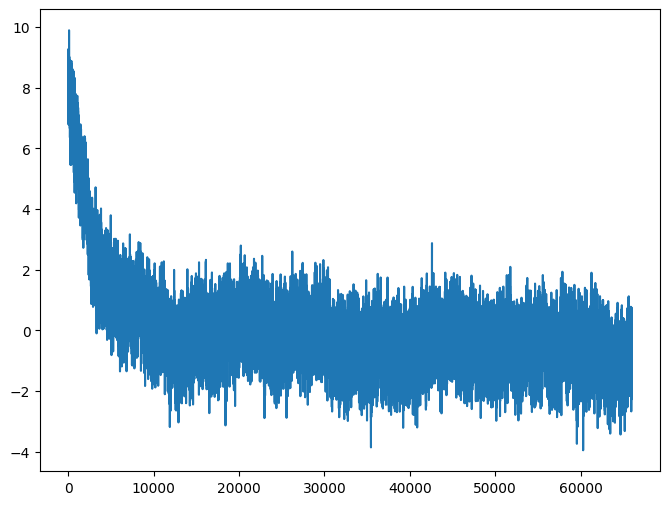

[3.91394761e-31 4.53748917e+01 2.25481300e+01 ... 9.04180929e-05
 2.54658688e-05 1.07592911e-05]


In [26]:
import scipy
principle_components = data_processing_tools.get_principle_components(
    on_res_df_timestreams, number_of_components=1, plot_components=False
)

print(principle_components.flatten())
print(principle_components.size)
plt.figure(figsize=(8, 6))
plt.plot(principle_components)
plt.show()

(frequencies, psd) = scipy.signal.periodogram(
                principle_components.flatten(), multi_tone_timestreams.on_res_timestreams_array[0].sample_rate, scaling="density"
)
print(psd)
plt.figure(figsize=(8, 6))
plt.plot(frequencies[1:], psd[1:])
plt.xscale("log")
plt.yscale("log")
plt.ylabel("Sxx")
plt.show()

Starting PCA
PCA Complete
[-0.25444566  0.00983012 -0.77753421 ...  1.43976443  1.90251248
  1.87264144]
66016


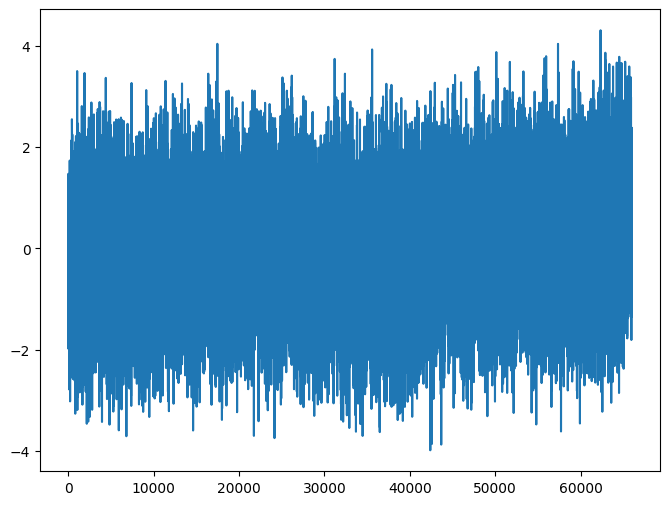

[6.56932969e-33 1.26036739e+00 2.21675633e+00 ... 2.87493872e-04
 1.02888837e-04 1.89510960e-06]


In [25]:
principle_components = data_processing_tools.get_principle_components(
    off_res_df_timestreams, number_of_components=1, plot_components=False
)

print(principle_components.flatten())
print(principle_components.size)
plt.figure(figsize=(8, 6))
plt.plot(principle_components)
plt.show()

(frequencies, psd) = scipy.signal.periodogram(
                principle_components.flatten(), multi_tone_timestreams.on_res_timestreams_array[0].sample_rate, scaling="density"
)
print(psd)
plt.figure(figsize=(8, 6))
plt.plot(frequencies[1:], psd[1:])
plt.xscale("log")
plt.yscale("log")
plt.show()

In [8]:
# Plot original and cleaned timestreams:
time_array = multi_tone_timestreams.on_res_timestreams_array[
    0
].timestream_time_data
n_timestreams = on_res_df_timestreams.shape[0]
n_columns = 4
n_rows = math.ceil(n_timestreams / n_columns)

while n_rows == 1:
    n_columns -= 1
    n_rows = math.ceil(n_timestreams / n_columns)

# On resonance timestreams:
print("Plotting on resonance timestreams")
row = 0
column = 0
figure, axes = plt.subplots(
    n_rows, n_columns, sharex=True, figsize=(14, n_rows * 2)
)
for count, timestream in enumerate(cleaned_on_res_df_data):
    axes[row][column].plot(
        time_array, on_res_df_timestreams[count], label="Original"
    )
    axes[row][column].plot(time_array, timestream, label="Cleaned")
    axes[row][column].set_title(multi_tone_timestreams.tone_name_array[count])

    if column == 0:
        axes[row][column].set_ylabel("df/f")

    if row == n_rows - 1:
        axes[row][column].set_xlabel("Time (s)")

    column += 1
    if column == n_columns:
        column = 0
        row += 1

# Remove extra subplots:
remaining_subplots = (n_columns * n_rows) - n_timestreams
if remaining_subplots > 0:
    for remaining_column in range(remaining_subplots):
        axes[row][column + remaining_column].remove()


plt.suptitle("On Resonance df Timestreams")

handles, labels = axes[0][0].get_legend_handles_labels()
figure.legend(
    handles=handles,
    labels=labels,
    loc="lower center",
    ncol=2,
)
plt.tight_layout(rect=(0, 0.1, 1, 1))
if save_figures:
    plt.savefig(
        "../../Figures/"
        + f"Multi_tone_on_res_timestreams_for_{dut}_at_{temperature}K_"
        f"{multi_tone_timestreams.bias_power_array[0]}amp.png",
        bbox_inches="tight",
    )
plt.show()

Plotting on resonance timestreams


Plotting off resonance timestreams


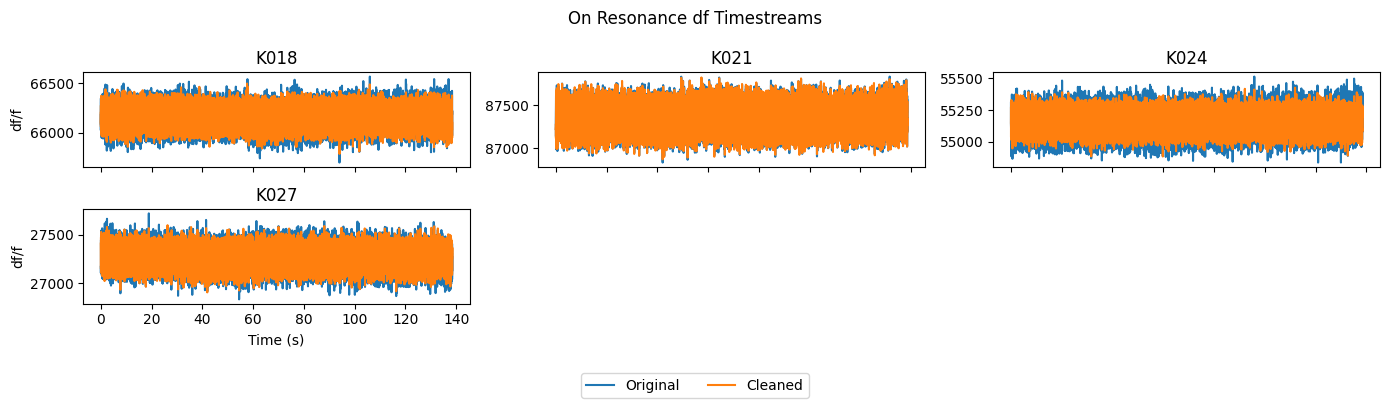

In [9]:
# Off resonance timestreams:
print("Plotting off resonance timestreams")
row = 0
column = 0
figure, axes = plt.subplots(
  n_rows, n_columns, sharex=True, figsize=(14, n_rows * 2)
)
for count, timestream in enumerate(cleaned_off_res_df_data):
  axes[row][column].plot(
      time_array, off_res_df_timestreams[count], label="Original"
  )
  axes[row][column].plot(time_array, timestream, label="Cleaned")
  axes[row][column].set_title(multi_tone_timestreams.tone_name_array[count])

  if column == 0:
      axes[row][column].set_ylabel("df/f")

  if row == n_rows - 1:
      axes[row][column].set_xlabel("Time (s)")

  column += 1
  if column == n_columns:
      column = 0
      row += 1

# Remove extra subplots:
remaining_subplots = (n_columns * n_rows) - n_timestreams
if remaining_subplots > 0:
  for remaining_column in range(remaining_subplots):
      axes[row][column + remaining_column].remove()

plt.suptitle("On Resonance df Timestreams")

handles, labels = axes[0][0].get_legend_handles_labels()
figure.legend(
  handles=handles,
  labels=labels,
  loc="lower center",
  ncol=2,
)
plt.tight_layout(rect=(0, 0.1, 1, 1))
if save_figures:
  plt.savefig(
      "../../Figures/"
      + f"Multi_tone_off_res_timestreams_for_{dut}_at_{temperature}K_"
      f"{multi_tone_timestreams.bias_power_array[0]}amp.png",
      bbox_inches="tight",
  )
plt.show()

In [10]:
multi_tone_noise_packet_array = np.empty_like(
    tone_names, dtype=object
)
cleaned_multi_tone_noise_packet_array = np.empty_like(
    tone_names, dtype=object
)

for count, tone in enumerate(tone_names):

    current_noise_sweep = NoiseSweep(
        dut=dut,
        tone_name=tone,
        temperature=temperature,
        input_attenuation=multi_tone_timestreams.bias_power_array[count],
        sweep_data=multi_tone_timestreams.sweep_data_array[count],
    )

    (
        on_res_psd,
        on_res_frequencies,
    ) = resonator_noise_analysis_tools.get_mean_psd(
        number_of_timestreams=1,
        df_timestreams_array=np.array([on_res_df_timestreams[count]])
        / current_noise_sweep.sweep_f0,
        sample_rate=multi_tone_timestreams.on_res_timestreams_array[
            count
        ].sample_rate,
        down_sample=True,
        down_sample_bins=100,
    )

    (
        off_res_psd,
        off_res_frequencies,
    ) = resonator_noise_analysis_tools.get_mean_psd(
        number_of_timestreams=1,
        df_timestreams_array=np.array([off_res_df_timestreams[count]])
        / current_noise_sweep.sweep_f0,
        sample_rate=multi_tone_timestreams.off_res_timestreams_array[
            count
        ].sample_rate,
        down_sample=True,
        down_sample_bins=100,
    )

    (
        cleaned_on_res_psd,
        cleaned_on_res_frequencies,
    ) = resonator_noise_analysis_tools.get_mean_psd(
        number_of_timestreams=1,
        df_timestreams_array=np.array([cleaned_on_res_df_data[count]])
        / current_noise_sweep.sweep_f0,
        sample_rate=multi_tone_timestreams.on_res_timestreams_array[
            count
        ].sample_rate,
        down_sample=True,
        down_sample_bins=100,
    )

    (
        cleaned_off_res_psd,
        cleaned_off_res_frequencies,
    ) = resonator_noise_analysis_tools.get_mean_psd(
        number_of_timestreams=1,
        df_timestreams_array=np.array([cleaned_off_res_df_data[count]])
        / current_noise_sweep.sweep_f0,
        sample_rate=multi_tone_timestreams.off_res_timestreams_array[
            count
        ].sample_rate,
        down_sample=True,
        down_sample_bins=100,
    )

    noise_packet = SimpleNoisePacketPSD(
        dut=dut,
        tone_name=tone,
        temperature=temperature,
        input_attenuation=multi_tone_timestreams.bias_power_array[count],
        sampling_rate=multi_tone_timestreams.off_res_timestreams_array[
            count
        ].sample_rate,
        noise_sweep=current_noise_sweep,
        on_res_psd=on_res_psd,
        on_res_frequencies=on_res_frequencies,
        off_res_psd=off_res_psd,
        off_res_frequencies=off_res_frequencies,
    )

    cleaned_noise_packet = SimpleNoisePacketPSD(
        dut=dut,
        tone_name=tone,
        temperature=temperature,
        input_attenuation=multi_tone_timestreams.bias_power_array[count],
        sampling_rate=multi_tone_timestreams.off_res_timestreams_array[
            count
        ].sample_rate,
        noise_sweep=current_noise_sweep,
        on_res_psd=cleaned_on_res_psd,
        on_res_frequencies=cleaned_on_res_frequencies,
        off_res_psd=cleaned_off_res_psd,
        off_res_frequencies=cleaned_off_res_frequencies,
    )

    noise_packet.correct_psd_for_cic_filter(trim_percentage=0.0001)
    cleaned_noise_packet.correct_psd_for_cic_filter(trim_percentage=0.0001)

    multi_tone_noise_packet_array[count] = noise_packet
    cleaned_multi_tone_noise_packet_array[count] = cleaned_noise_packet

print("PSD's complete, plotting...")

PSD's complete, plotting...


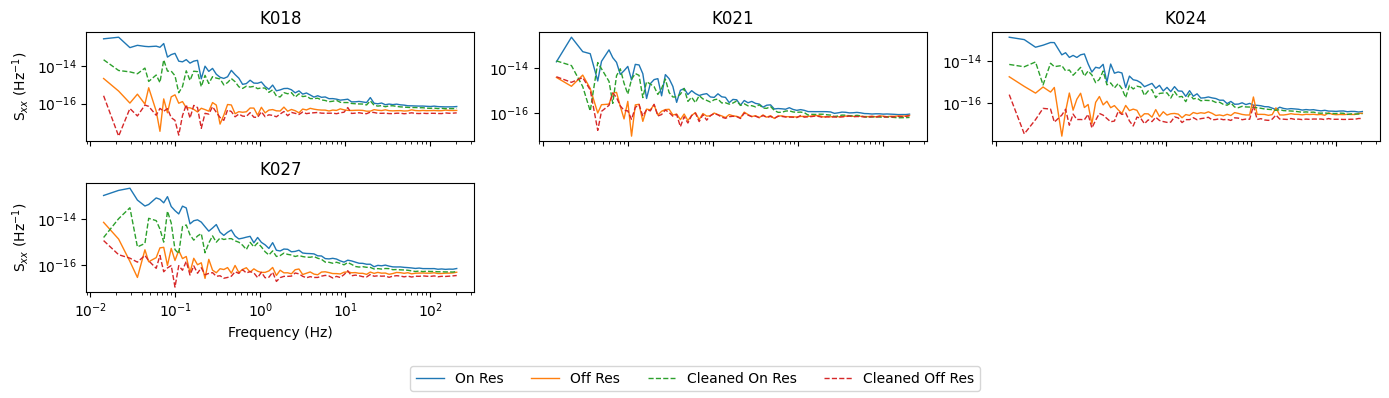

In [11]:
n_plots = multi_tone_noise_packet_array.shape[0]
n_columns = 4
n_rows = math.ceil(n_plots / n_columns)

while n_rows == 1:
    n_columns -= 1
    n_rows = math.ceil(n_timestreams / n_columns)

row = 0
column = 0
figure, axes = plt.subplots(
    n_rows, n_columns, sharex=True, figsize=(14, n_rows * 2)
)
for count, noise_packet in enumerate(multi_tone_noise_packet_array):
    axes[row][column].plot(
        noise_packet.on_res_frequencies,
        noise_packet.on_res_psd,
        label="On Res",
        linewidth=1,
    )
    axes[row][column].plot(
        noise_packet.off_res_frequencies,
        noise_packet.off_res_psd,
        label="Off Res",
        linewidth=1,
    )
    axes[row][column].plot(
        cleaned_multi_tone_noise_packet_array[count].on_res_frequencies,
        cleaned_multi_tone_noise_packet_array[count].on_res_psd,
        label="Cleaned On Res",
        linewidth=1,
        linestyle="--",
    )
    axes[row][column].plot(
        cleaned_multi_tone_noise_packet_array[count].off_res_frequencies,
        cleaned_multi_tone_noise_packet_array[count].off_res_psd,
        label="Cleaned Off Res",
        linewidth=1,
        linestyle="--",
    )

    axes[row][column].set_title(multi_tone_timestreams.tone_name_array[count])
    axes[row][column].set_xscale("log")
    axes[row][column].set_yscale("log")
    if column == 0:
        axes[row][column].set_ylabel("S$_{xx}$ (Hz$^{-1}$)")

    if row == n_rows - 1:
        axes[row][column].set_xlabel("Frequency (Hz)")
    column += 1
    if column == n_columns:
        column = 0
        row += 1

# Remove extra subplots:
remaining_subplots = (n_columns * n_rows) - n_plots
if remaining_subplots > 0:
    for remaining_column in range(remaining_subplots):
        axes[row][column + remaining_column].remove()

handles, labels = axes[0][0].get_legend_handles_labels()
figure.legend(
    handles=handles,
    labels=labels,
    loc="lower center",
    ncol=4,
)
plt.tight_layout(rect=(0, 0.1, 1, 1))
if save_figures:
    plt.savefig(
        "../../Figures/" + f"Multi_tone_PSD_subplots_for_{dut}_at_{temperature}K_"
        f"{multi_tone_timestreams.bias_power_array[0]}amp.png",
        bbox_inches="tight",
    )
plt.show()

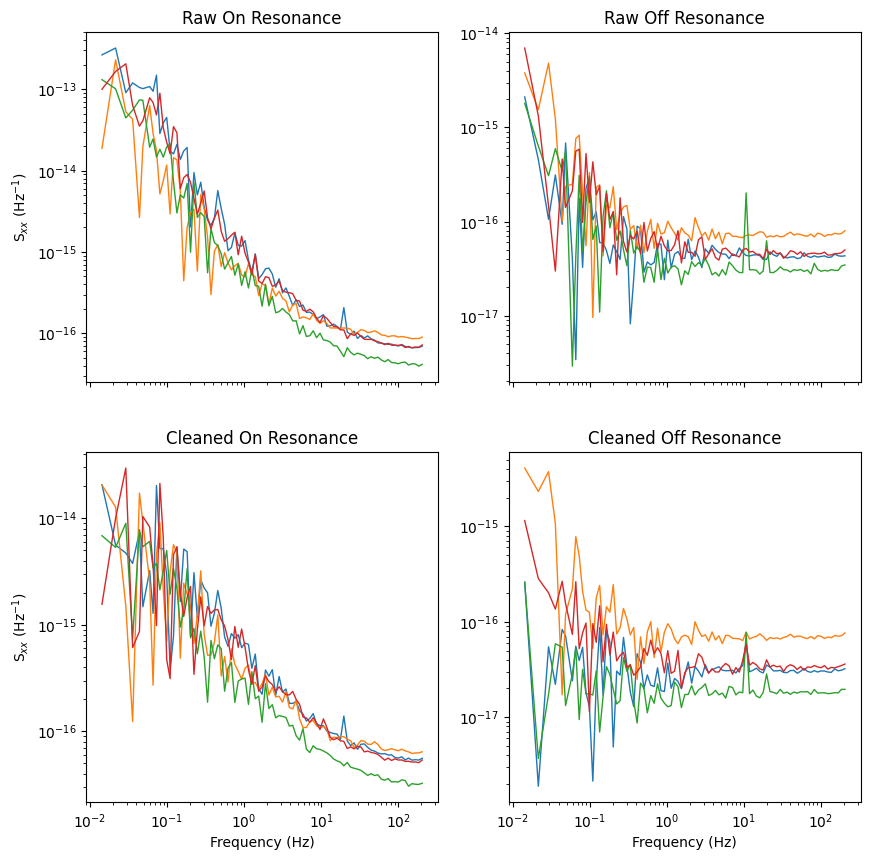

In [12]:
# Plot PSD's from multiple kids on same plot:

figure, axes = plt.subplots(2, 2, figsize=(10, 10), sharex=True)

for count, noise_packet in enumerate(multi_tone_noise_packet_array):

    # 1st axis
    axes[0][0].plot(noise_packet.on_res_frequencies, noise_packet.on_res_psd, linewidth=1)
    axes[0][0].set_title("Raw On Resonance")
    axes[0][0].set_ylabel("S$_{xx}$ (Hz$^{-1}$)")
    axes[0][0].set_xscale("log")
    axes[0][0].set_yscale("log")

    # 2nd axis
    axes[0][1].plot(noise_packet.off_res_frequencies, noise_packet.off_res_psd, linewidth=1)
    axes[0][1].set_title("Raw Off Resonance")
    axes[0][1].set_xscale("log")
    axes[0][1].set_yscale("log")

    # 3rd axis
    axes[1][0].plot(
        cleaned_multi_tone_noise_packet_array[count].on_res_frequencies,
        cleaned_multi_tone_noise_packet_array[count].on_res_psd,
        linewidth=1
    )
    axes[1][0].set_title("Cleaned On Resonance")
    axes[1][0].set_ylabel("S$_{xx}$ (Hz$^{-1}$)")
    axes[1][0].set_xlabel("Frequency (Hz)")
    axes[1][0].set_xscale("log")
    axes[1][0].set_yscale("log")

    # 4th axis
    axes[1][1].plot(
        cleaned_multi_tone_noise_packet_array[count].off_res_frequencies,
        cleaned_multi_tone_noise_packet_array[count].off_res_psd,
        linewidth=1
    )
    axes[1][1].set_title("Cleaned Off Resonance")
    axes[1][1].set_xlabel("Frequency (Hz)")
    axes[1][1].set_xscale("log")
    axes[1][1].set_yscale("log")

if save_figures:
    plt.savefig(
        "../../Figures/" + f"Multi_tone_PSDs_in_one_for_{dut}_at_{temperature}K_"
        f"{multi_tone_timestreams.bias_power_array[0]}amp.png",
        bbox_inches="tight",
    )
plt.show()

In [13]:
s1 = np.random.normal(0.01, 0.001, t.size) * lorentzian_values_1
s2 = np.random.normal(0.03, 0.002, t.size) * lorentzian_values_1

cleaned_data = pca_clean_timestream(np.array([s1, s2]), 1)

figure, axes = plt.subplots(2)
axes[0].plot(t, s1, color="b", label="Original")
axes[1].plot(t, s2, color="b", label="Original")

axes[0].plot(t, cleaned_data[0], color="r", label="Cleaned")
axes[1].plot(t, cleaned_data[1], color="r", label="Cleaned")

axes[1].legend()
plt.suptitle("Perfectly correlated Data")
plt.show()


NameError: name 't' is not defined

In [ ]:
s1 = np.random.normal(0.01, 0.001, t.size) * lorentzian_values_1
s2 = np.random.normal(0.03, 0.002, t.size) * lorentzian_values_2

cleaned_data = pca_clean_timestream(np.array([s1, s2]), 1)

figure, axes = plt.subplots(2)
axes[0].plot(t, s1, color="b", label="Original")
axes[1].plot(t, s2, color="b", label="Original")

axes[0].plot(t, cleaned_data[0], color="r", label="Cleaned")
axes[1].plot(t, cleaned_data[1], color="r", label="Cleaned")

axes[1].legend()
plt.suptitle("Uncorrelated - Common Glitch Data")
plt.show()

In [ ]:
s1 = np.random.normal(0.01, 0.001, t.size) * lorentzian_values_1
s2 = np.random.normal(0.03, 0.002, t.size) * lorentzian_values_2
s1 = z_score_standardisation(s1)
s2 = z_score_standardisation(s2)
correlation = correlate(s1, s2, mode="same", method="auto")

figure, axes = plt.subplots(4)
axes[0].plot(t, s1)
axes[1].plot(t, s2)
axes[2].plot(t, correlation)
axes[3].plot(t[:-1], np.diff(correlation))
plt.show()

In [ ]:
s1 = np.random.normal(0.01, 0.001, t.size) * lorentzian_values_1
s2 = np.random.normal(0.03, 0.002, t.size) * lorentzian_values_2 * lorentzian_values_3
s1 = z_score_standardisation(s1)
s2 = z_score_standardisation(s2)
correlation = correlate(s1, s2, mode="same", method="auto")

figure, axes = plt.subplots(4)
axes[0].plot(t, s1)
axes[1].plot(t, s2)
axes[2].plot(t, correlation)
axes[3].plot(t[:-1], np.diff(correlation))
plt.show()

In [ ]:
s1 = np.random.normal(0.01, 0.001, t.size) * lorentzian_values_1
s2 = np.random.normal(0.03, 0.002, t.size) * lorentzian_values_2
s1 = z_score_standardisation(s1)
s2 = z_score_standardisation(s2)
correlation = correlate(s1, s2, mode="same", method="auto")

figure, axes = plt.subplots(4)
axes[0].plot(t, s1)
axes[1].plot(t, s2)
axes[2].plot(t, correlation)
axes[3].plot(t[:-1], np.diff(correlation))
plt.show()

In [ ]:
from sklearn.decomposition import PCA, FastICA

s1 = np.random.normal(0.01, 0.001, t.size) * lorentzian_values_3
s2 = np.random.normal(0.03, 0.002, t.size) * lorentzian_values_3
s1 = z_score_standardisation(s1)
s2 = z_score_standardisation(s2)
correlation = correlate(s1, s2, mode="same", method="auto")

figure, axes = plt.subplots(4)
axes[0].plot(t, s1)
axes[1].plot(t, s2)
axes[2].plot(t, correlation)
axes[3].plot(t[:-1], np.diff(correlation))
plt.show()

In [ ]:


ica = FastICA(n_components=3, whiten="arbitrary-variance")
signals = ica.fit_transform(data[0])

# Transform the data into principal components
# pca_data = pca.transform(data)

figure, axes = plt.subplots(4)
axes[0].plot(t, s1)
axes[1].plot(t, s2)
axes[2].plot(t, correlation)
axes[3].plot(signals)
plt.show()
